# 고장시점 선형예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

# 데이터

In [21]:
df_train = pd.read_csv('PM_train_pre.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [3]:
df_test = pd.read_csv('PM_test_pre.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0,0


In [4]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

# 회귀분석 성능 지표

In [5]:
def get_regression_metrics(model, actual, predicted):
    regr_metrics = {
      'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
      'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
      'R^2' : metrics.r2_score(actual, predicted)}

    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

## 상관 계수와 중요 특성값

In [6]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

## 잔차를 그리는 함수

In [7]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data', s=2)
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data', s=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

# 회귀 분석
## 선형 모델

In [8]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.327


,Linear Regression
Root Mean Squared Error,48.399484
Mean Absolute Error,37.173907
R^2,0.326553


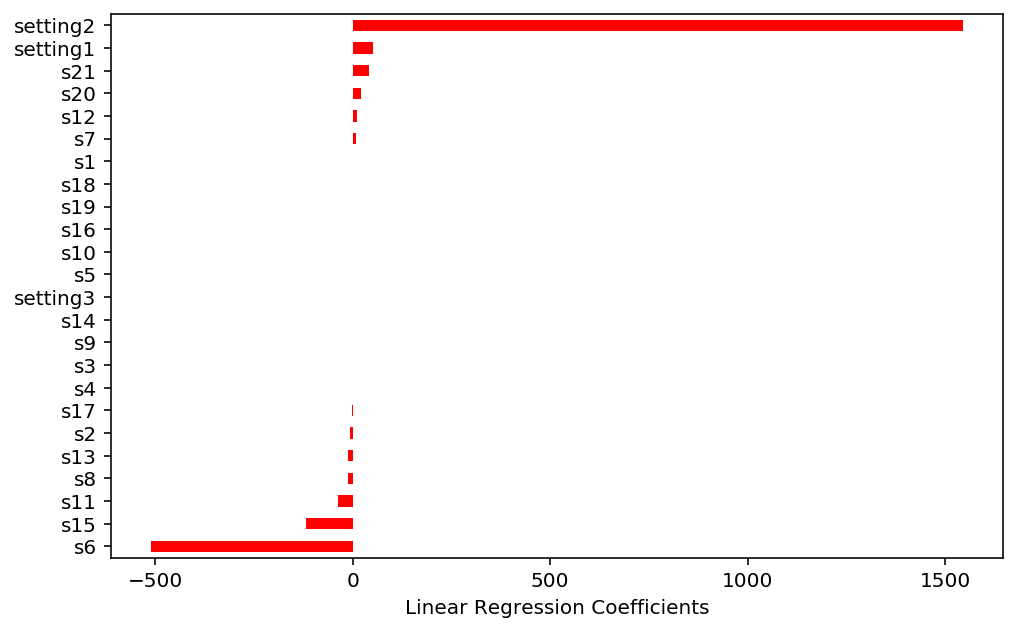

In [9]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

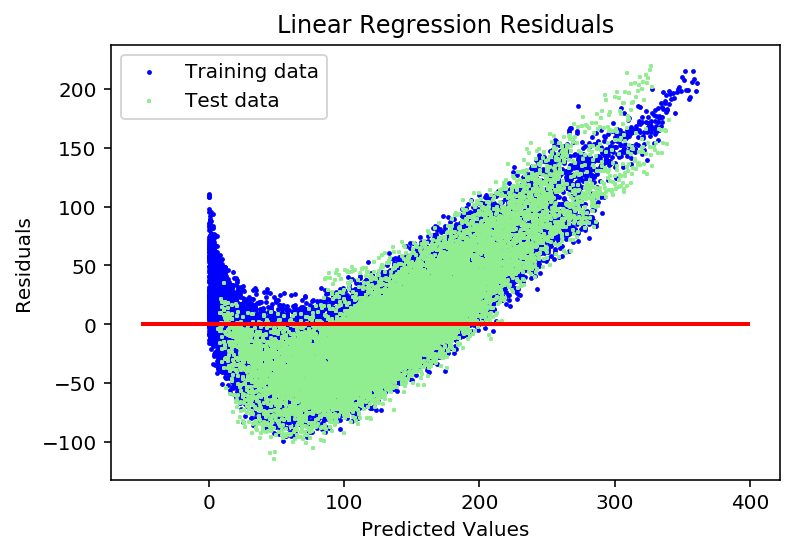

In [10]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## 다차항 모델

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.373


,Polynomial Regression
Root Mean Squared Error,46.703581
Mean Absolute Error,35.276368
R^2,0.372921


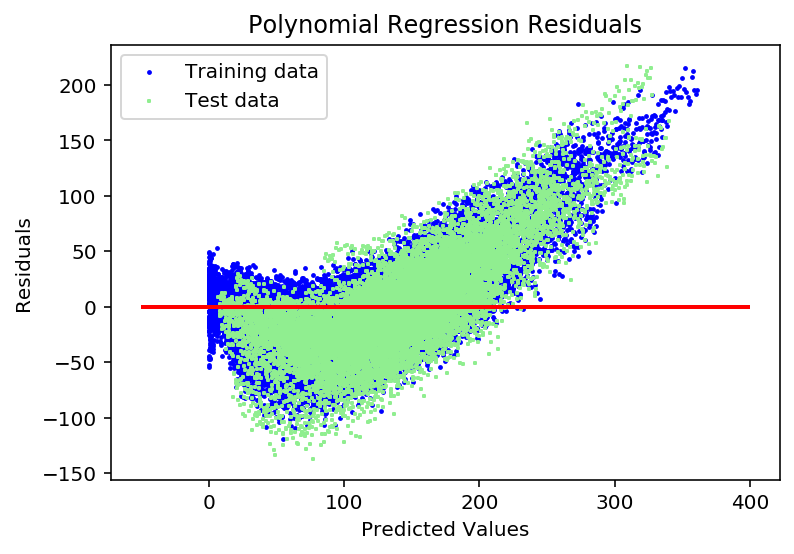

In [16]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

- Polynomial 회귀의 성능이 선형 모델보다 더 낫다

## 랜덤 포레스트

In [17]:
rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4) # original features

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.590, R^2 test: 0.310


,Random Forest Regression
Root Mean Squared Error,48.983642
Mean Absolute Error,37.457232
R^2,0.310199


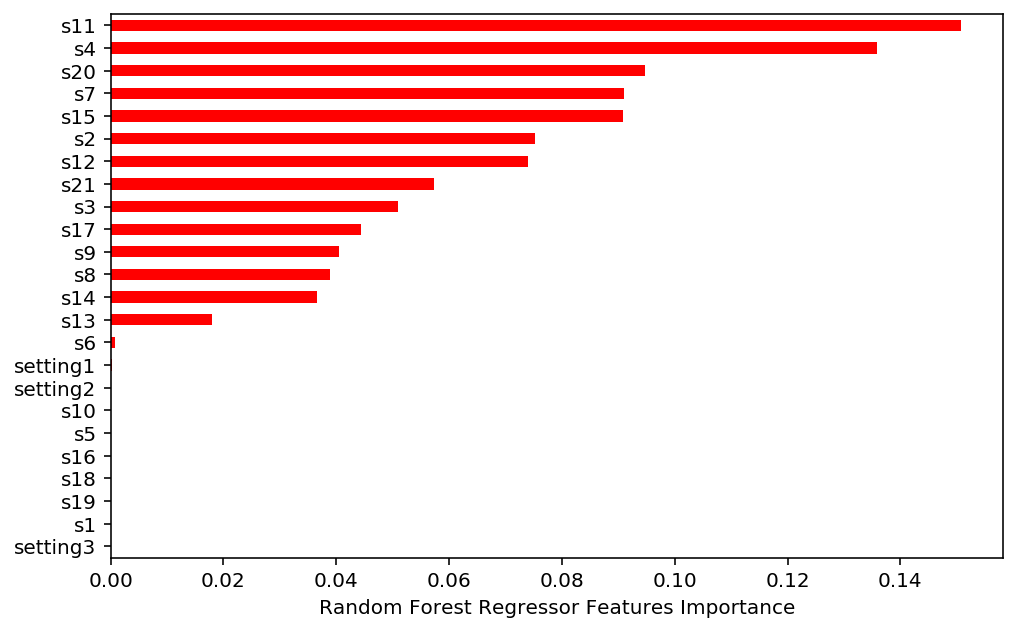

In [18]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

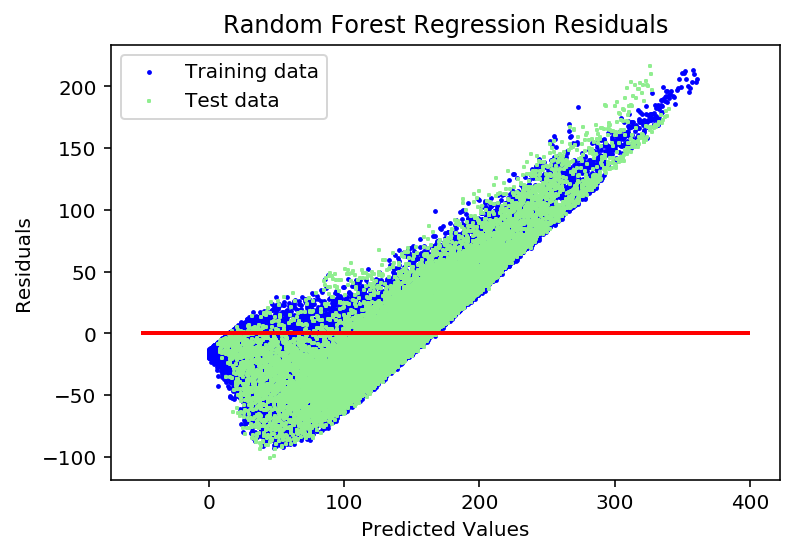

In [19]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

### 실제값과 예측치 보기

In [22]:
rf_pred_dict = {
    'Actual' : y_test,
    'Prediction' : y_test_predict }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred[:20].T

,Actual,Prediction
0,142.0,147.276146
1,141.0,152.849096
2,140.0,145.722032
3,139.0,146.637737
4,138.0,159.757279
...,...,...
13091,24.0,49.422347
13092,23.0,62.142627
13093,22.0,72.133595
13094,21.0,58.649976
